# Traffic Smoothing

In [22]:
import sys
sys.path.insert(1, '../../../../utils')
import numpy as np
from numpy import log, ndarray, array, mean, sqrt, arange
from pandas import read_csv, DataFrame, Series, to_timedelta, date_range, to_datetime
from matplotlib.pyplot import figure, savefig, show, subplots, plot, legend, setp
from matplotlib.figure import Figure
from matplotlib.axes import Axes
from matplotlib.gridspec import GridSpec
import dslabs_functions
from dslabs_functions import plot_line_chart, HEIGHT, ts_aggregation_by, set_chart_labels, plot_components, plot_multiline_chart, \
series_train_test_split, plot_forecasting_series, plot_multibar_chart, FORECAST_MEASURES, plot_forecasting_eval, plot_forecasting_series, \
PersistenceOptimistRegressor, PersistenceRealistRegressor
from scipy.stats import norm, expon, lognorm
from seaborn import heatmap
from statsmodels.tsa.stattools import adfuller
from sklearn.base import RegressorMixin
from sklearn.linear_model import LinearRegression

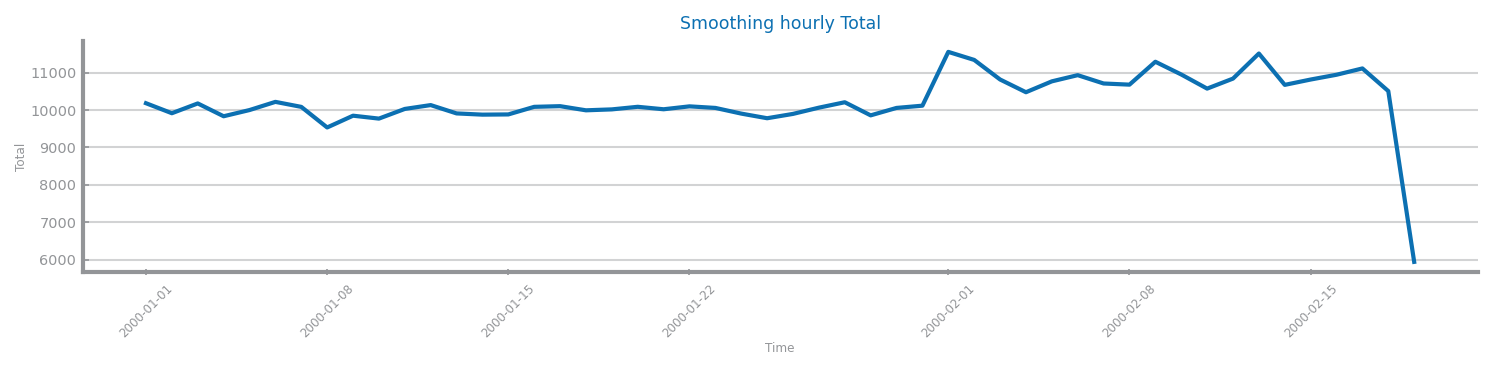

(Time
 2000-01-01    10185
 2000-01-02     9917
 2000-01-03    10179
 2000-01-04     9836
 2000-01-05    10002
 Name: Total, dtype: int64,
 Time
 2000-02-19     4975
 2000-02-20    10801
 2000-02-21    10960
 2000-02-22    11105
 2000-02-23    11100
 Name: Total, dtype: int64)

In [33]:
target = "Total"
chart_target = "Total"
file_tag = "Smoothing"

# Using aggregation result because differentation took no effect on improving performance
train_path = "../../data/prepared/aggregation/traffic_train_aggregation.csv" 
test_path  = "../../data/prepared/aggregation/traffic_test_aggregation.csv"

train_df = read_csv(train_path, parse_dates=["Time"], index_col="Time")
train: Series = train_df[target]
train.index = to_datetime(train.index)  # ensure proper datetime index

# Load test
test_df = read_csv(test_path, parse_dates=["Time"], index_col="Time")
test: Series = test_df[target]
test.index = to_datetime(test.index)

figure(figsize=(3 * HEIGHT, HEIGHT / 2))
plot_line_chart(
    train.index.to_list(),
    train.to_list(),
    xlabel=train.index.name,
    ylabel=target,
    title=f"{file_tag} hourly {target}",
)
show()
train.head(), test.head()

Window size 5: train=47, test=14
Window size 10: train=42, test=14
Window size 15: train=37, test=14
Window size 25: train=27, test=14


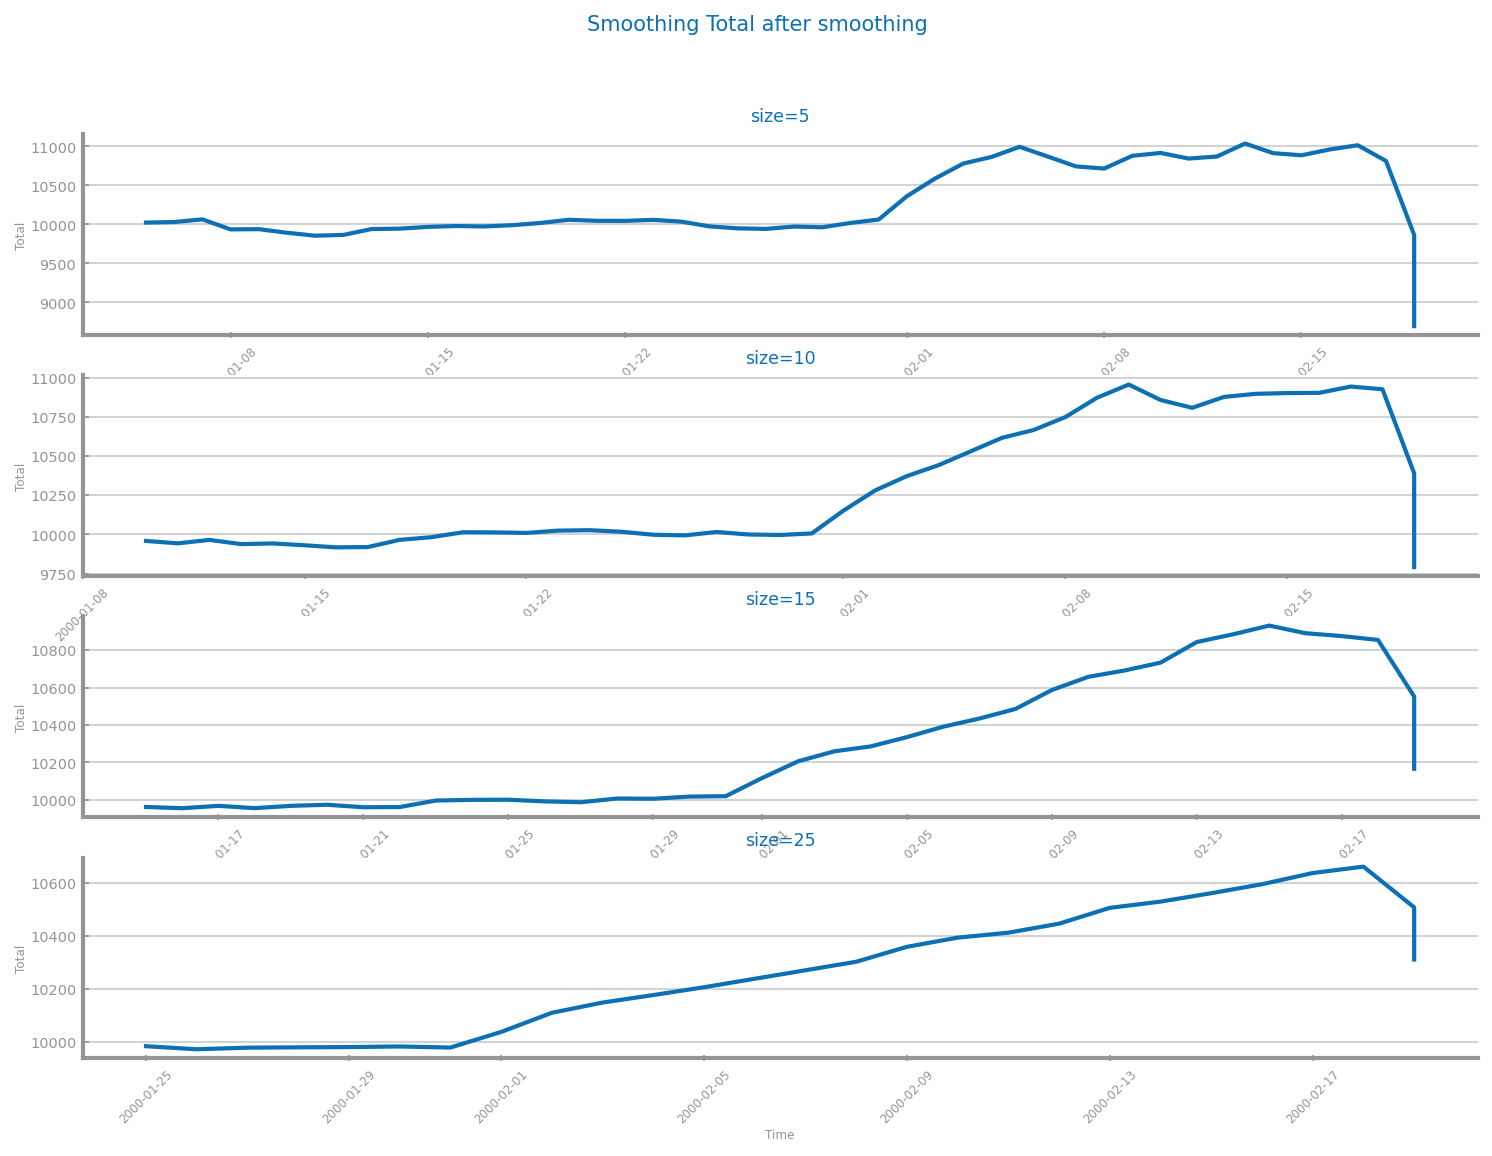

In [24]:
from matplotlib.pyplot import subplots
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from pandas import concat

sizes: list[int] = [5, 10, 15, 25]
fig: Figure
axs: list[Axes]
fig, axs = subplots(len(sizes), 1, figsize=(3 * HEIGHT, HEIGHT / 2 * len(sizes)))
fig.suptitle(f"{file_tag} {target} after smoothing")

ss_smooth_list: dict[str, Series] = {}

# Combine train and test to apply smoothing, then split
combined = concat([train, test])

for i in range(len(sizes)):
    # Apply smoothing to combined series
    ss_smooth_combined: Series = combined.rolling(window=sizes[i]).mean().dropna()
    
    # Split back into train and test based on the original indices
    # Train indices: all indices in train that are also in smoothed series
    ss_smoot_train = ss_smooth_combined[ss_smooth_combined.index.isin(train.index)]
    # Test indices: all indices in test that are also in smoothed series  
    ss_smoot_test = ss_smooth_combined[ss_smooth_combined.index.isin(test.index)]
    
    plot_line_chart(
        ss_smoot_train.index.to_list(),
        ss_smoot_train.to_list(),
        ax=axs[i],
        xlabel=ss_smoot_train.index.name,
        ylabel=target,
        title=f"size={sizes[i]}",
    )
    ss_smooth_list[f"size_{sizes[i]}_train"] = ss_smoot_train
    ss_smooth_list[f"size_{sizes[i]}_test"] = ss_smoot_test
    
    print(f"Window size {sizes[i]}: train={len(ss_smoot_train)}, test={len(ss_smoot_test)}")
show()

In [25]:
# Initialize metrics storage
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

metrics_results = {}

def store_metrics(model_name, window_size, train_series, test_series, prd_trn, prd_tst):
    """Store metrics for a given model and window size"""
    key = f"{model_name}_{window_size}"
    metrics_results[key] = {
        "model": model_name,
        "window_size": window_size,
        "train_rmse": sqrt(mean_squared_error(train_series, prd_trn)),
        "test_rmse": sqrt(mean_squared_error(test_series, prd_tst)),
        "train_mae": mean_absolute_error(train_series, prd_trn),
        "test_mae": mean_absolute_error(test_series, prd_tst),
        "train_mape": mean_absolute_percentage_error(train_series, prd_trn),
        "test_mape": mean_absolute_percentage_error(test_series, prd_tst),
        "train_r2": r2_score(train_series, prd_trn),
        "test_r2": r2_score(test_series, prd_tst),
    }
    return metrics_results[key]

PERSISTENCE REALIST EVALUATION
Completed: Persistence_Realist with window size 5
Completed: Persistence_Realist with window size 10
Completed: Persistence_Realist with window size 15
Completed: Persistence_Realist with window size 25


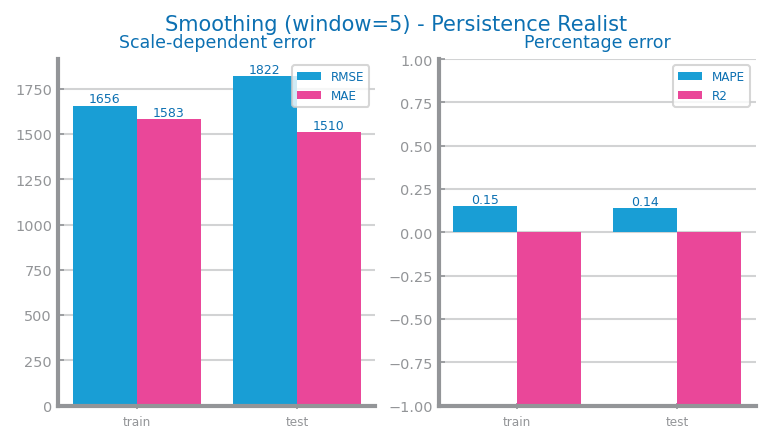

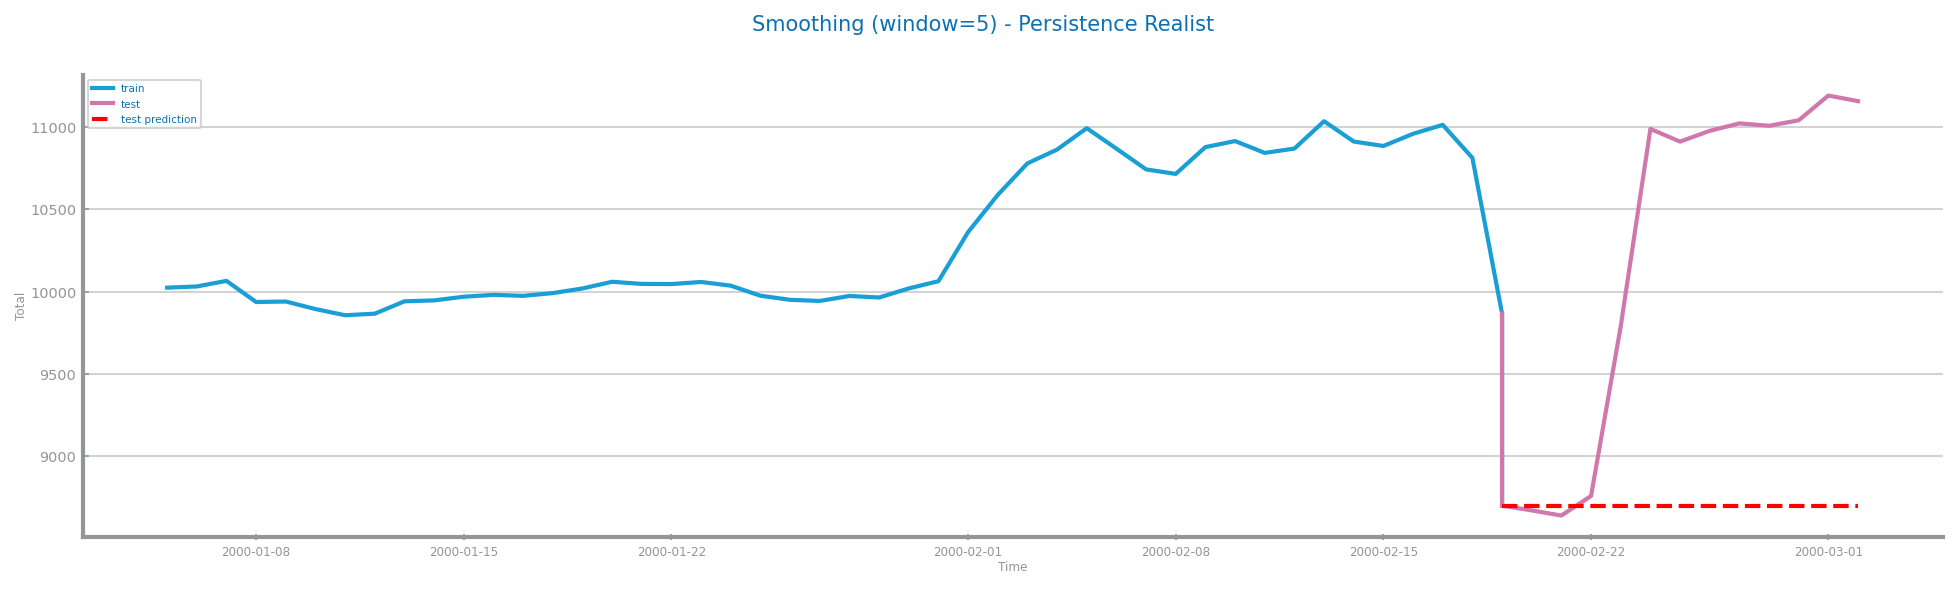

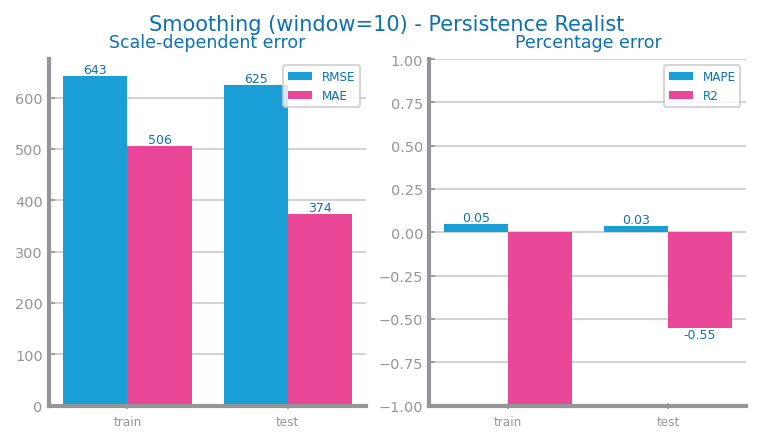

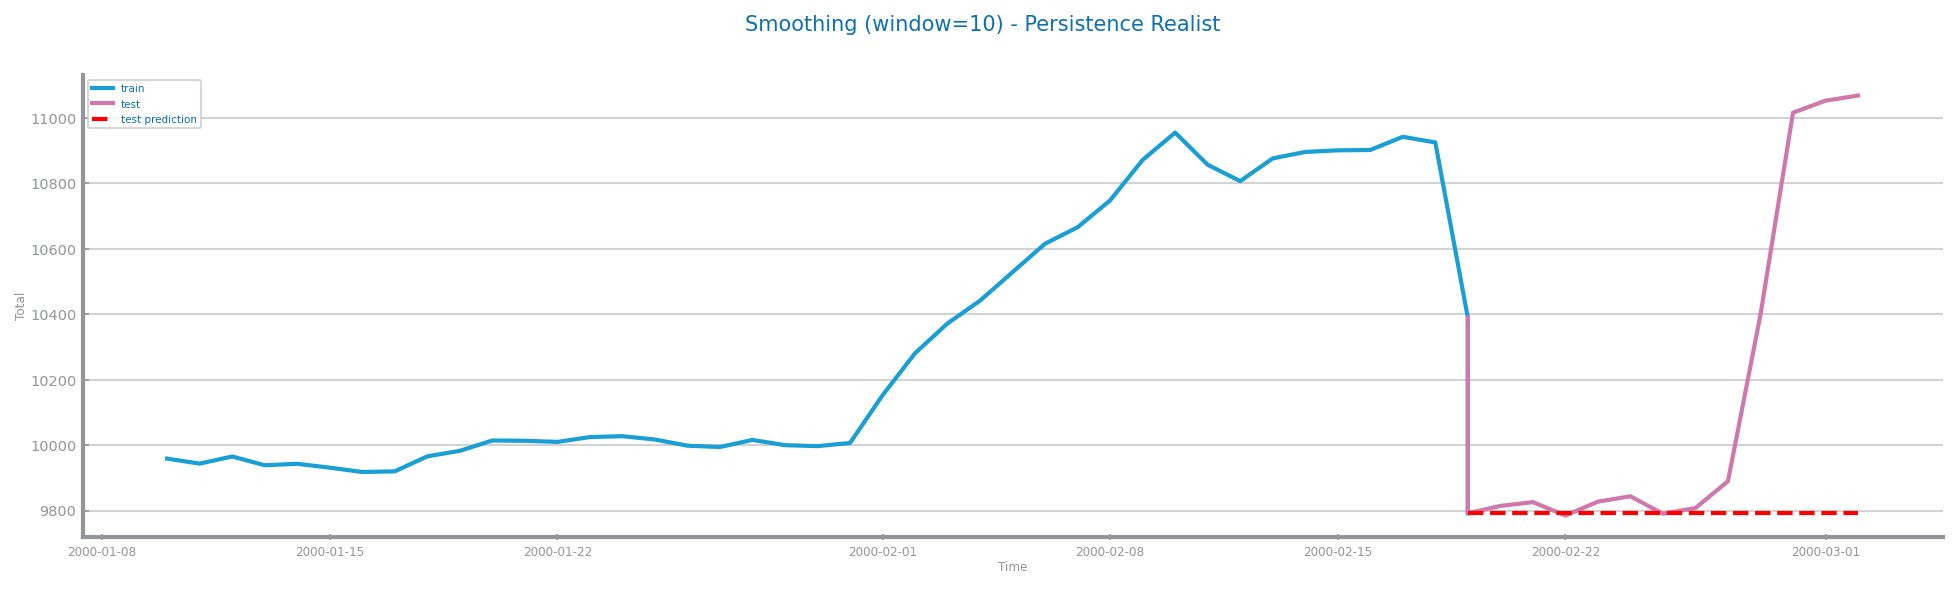

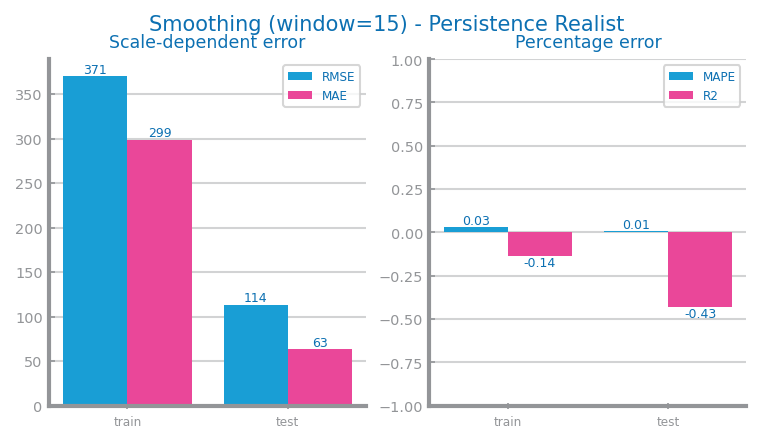

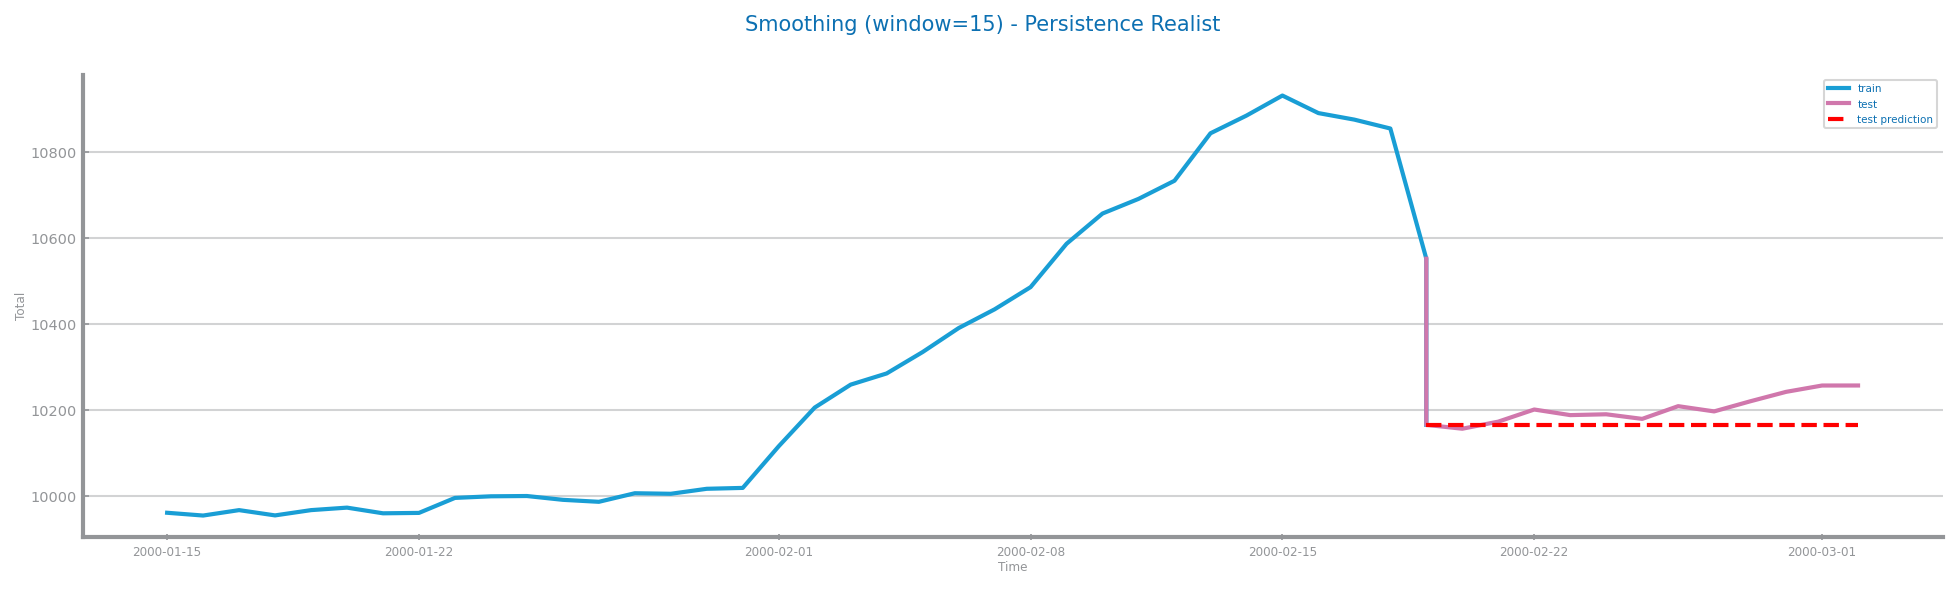

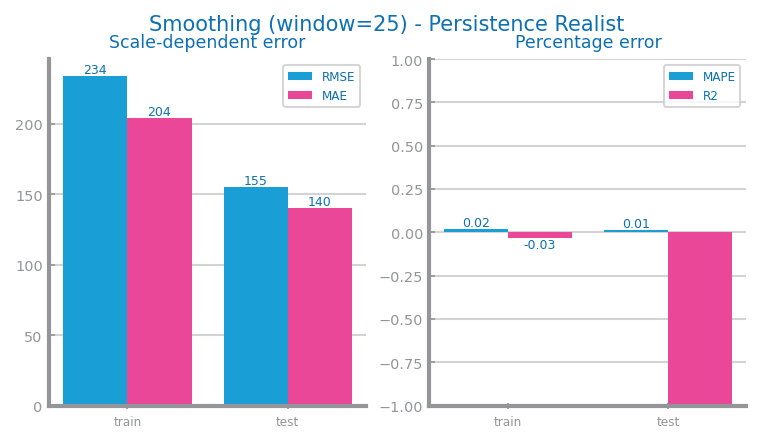

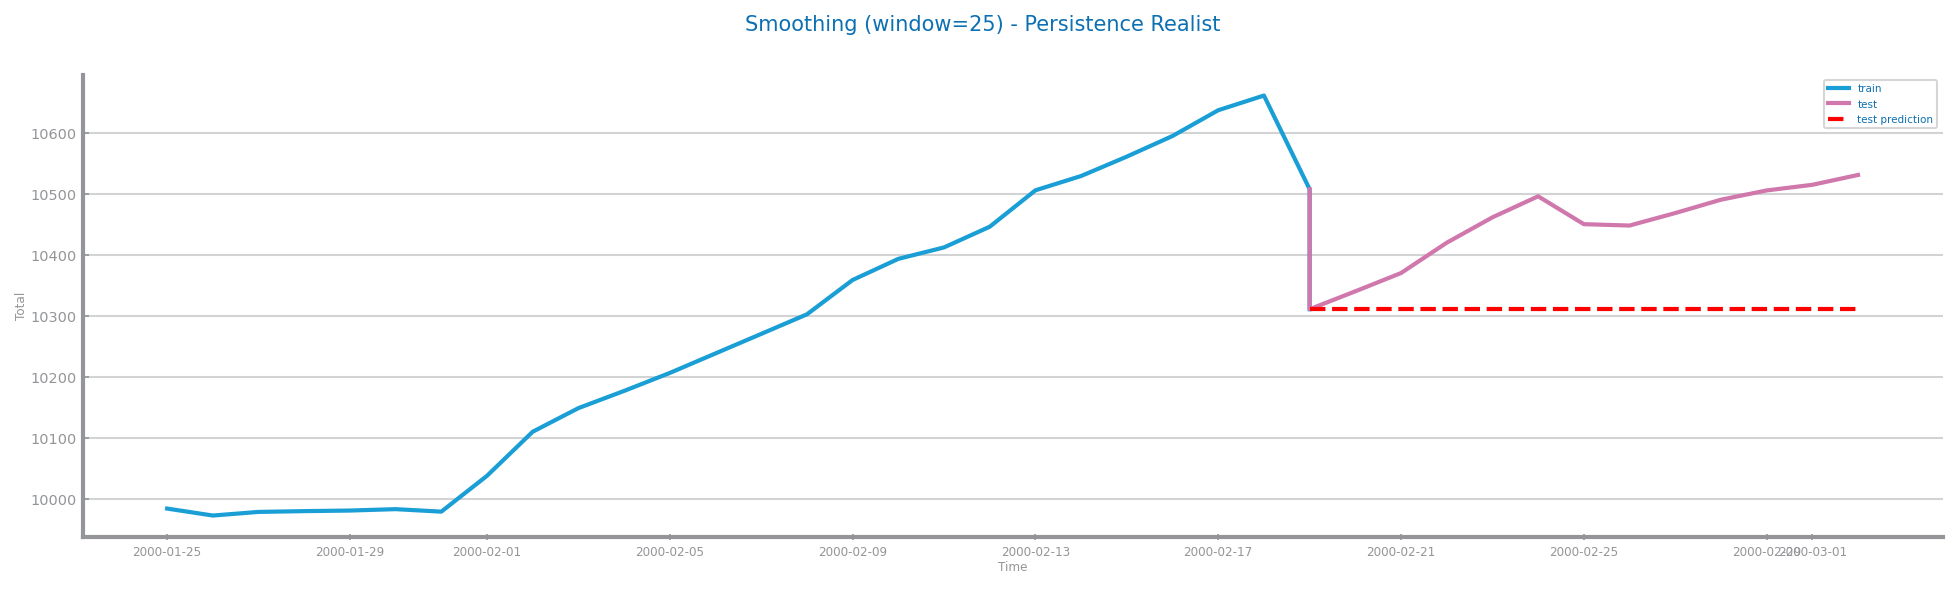

In [26]:
print("="*80)
print("PERSISTENCE REALIST EVALUATION")
print("="*80)

for size in sizes:
    smooth_train = ss_smooth_list[f"size_{size}_train"]
    smooth_test = ss_smooth_list[f"size_{size}_test"]
    
    # Check if we have enough data
    if len(smooth_test) == 0:
        print(f"Skipping window size {size}: test set is empty after smoothing")
        continue
    
    # Train and predict
    fr_mod = PersistenceRealistRegressor()
    fr_mod.fit(smooth_train)
    prd_trn = fr_mod.predict(smooth_train)
    prd_tst = fr_mod.predict(smooth_test)
    
    # Store metrics
    store_metrics("Persistence_Realist", size, smooth_train, smooth_test, prd_trn, prd_tst)
    
    # Plot evaluation
    plot_forecasting_eval(
        smooth_train, 
        smooth_test, 
        prd_trn, 
        prd_tst, 
        title=f"{file_tag} (window={size}) - Persistence Realist"
    )
    savefig(f"../../charts/preparation/smoothing/{file_tag}_persistence_real_size{size}_eval.png")
    
    # Plot forecast
    plot_forecasting_series(
        smooth_train,
        smooth_test,
        prd_tst,
        title=f"{file_tag} (window={size}) - Persistence Realist",
        xlabel="Time",
        ylabel=target,
    )
    savefig(f"../../charts/preparation/smoothing/{file_tag}_persistence_real_size{size}_forecast.png")
    
    print(f"Completed: Persistence_Realist with window size {size}")

LINEAR REGRESSION EVALUATION
Completed: Linear_Regression with window size 5
Completed: Linear_Regression with window size 10
Completed: Linear_Regression with window size 15
Completed: Linear_Regression with window size 25


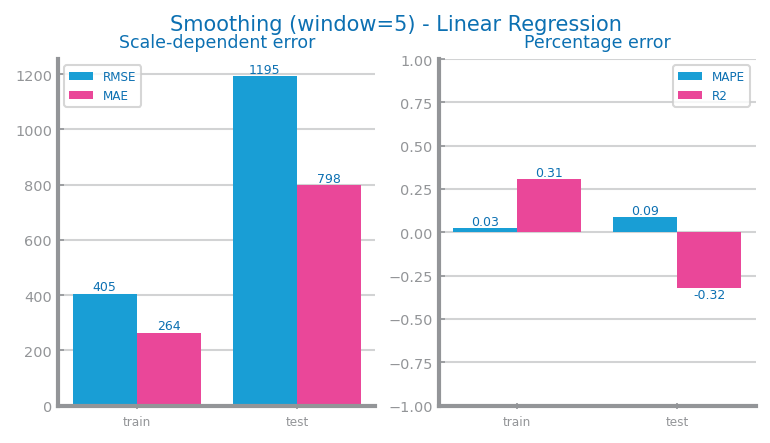

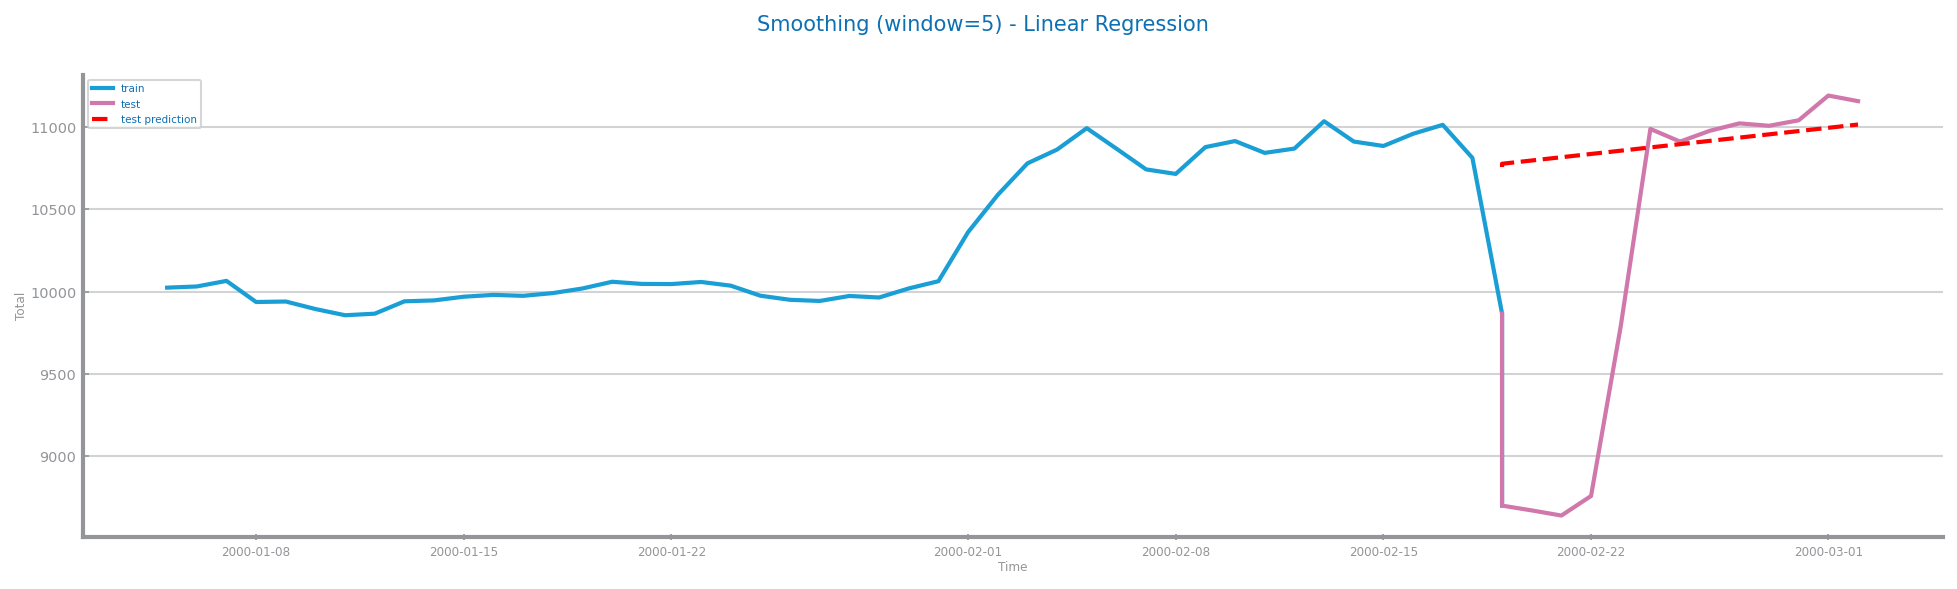

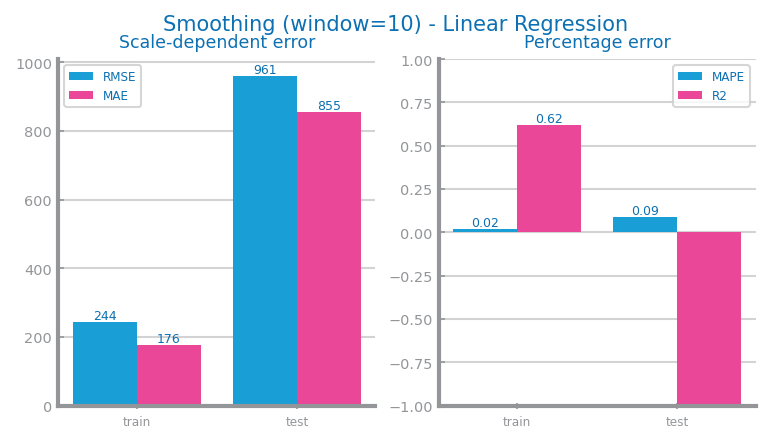

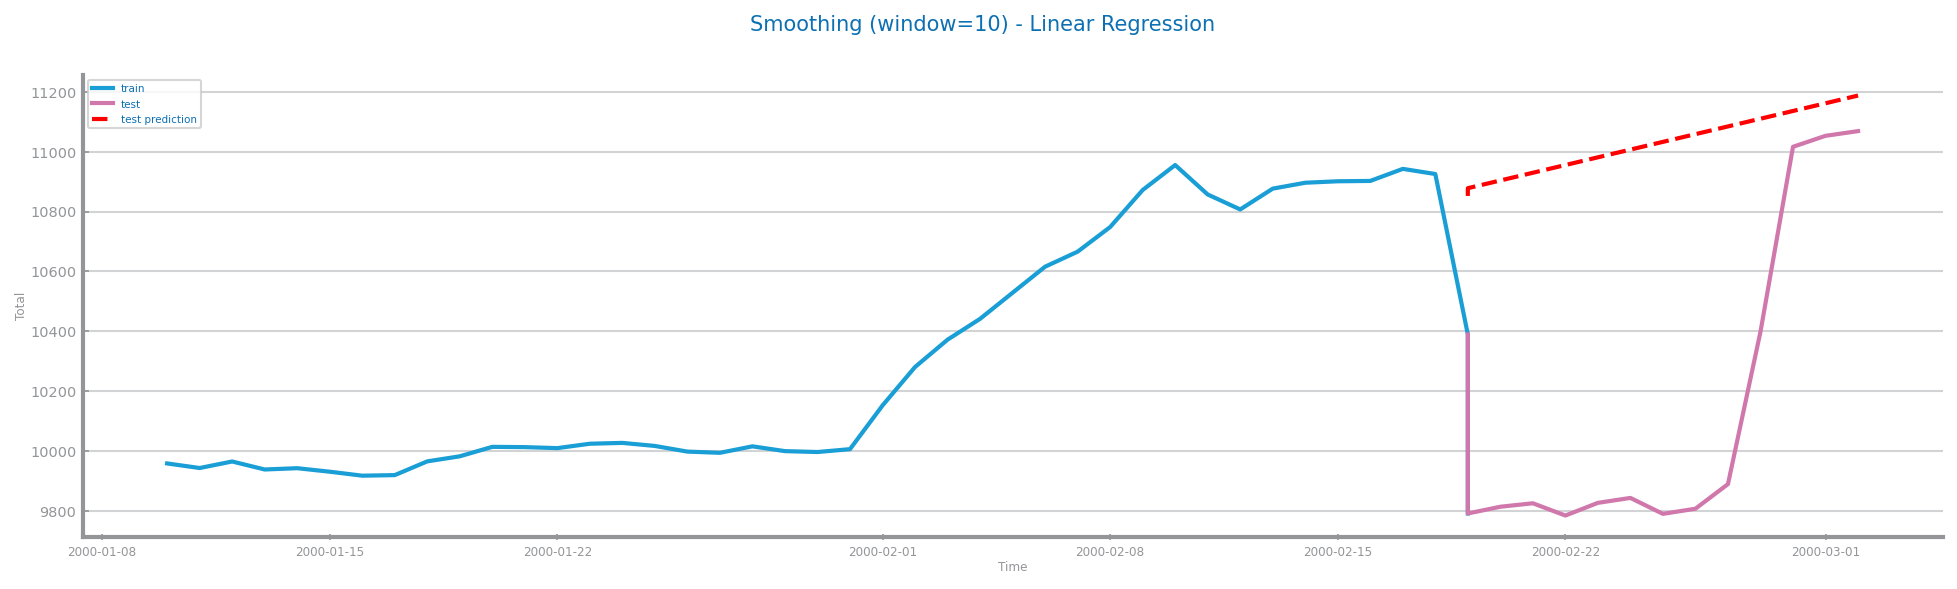

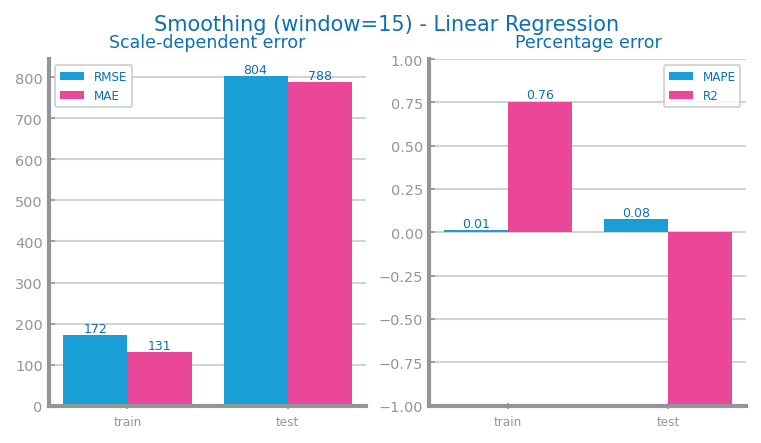

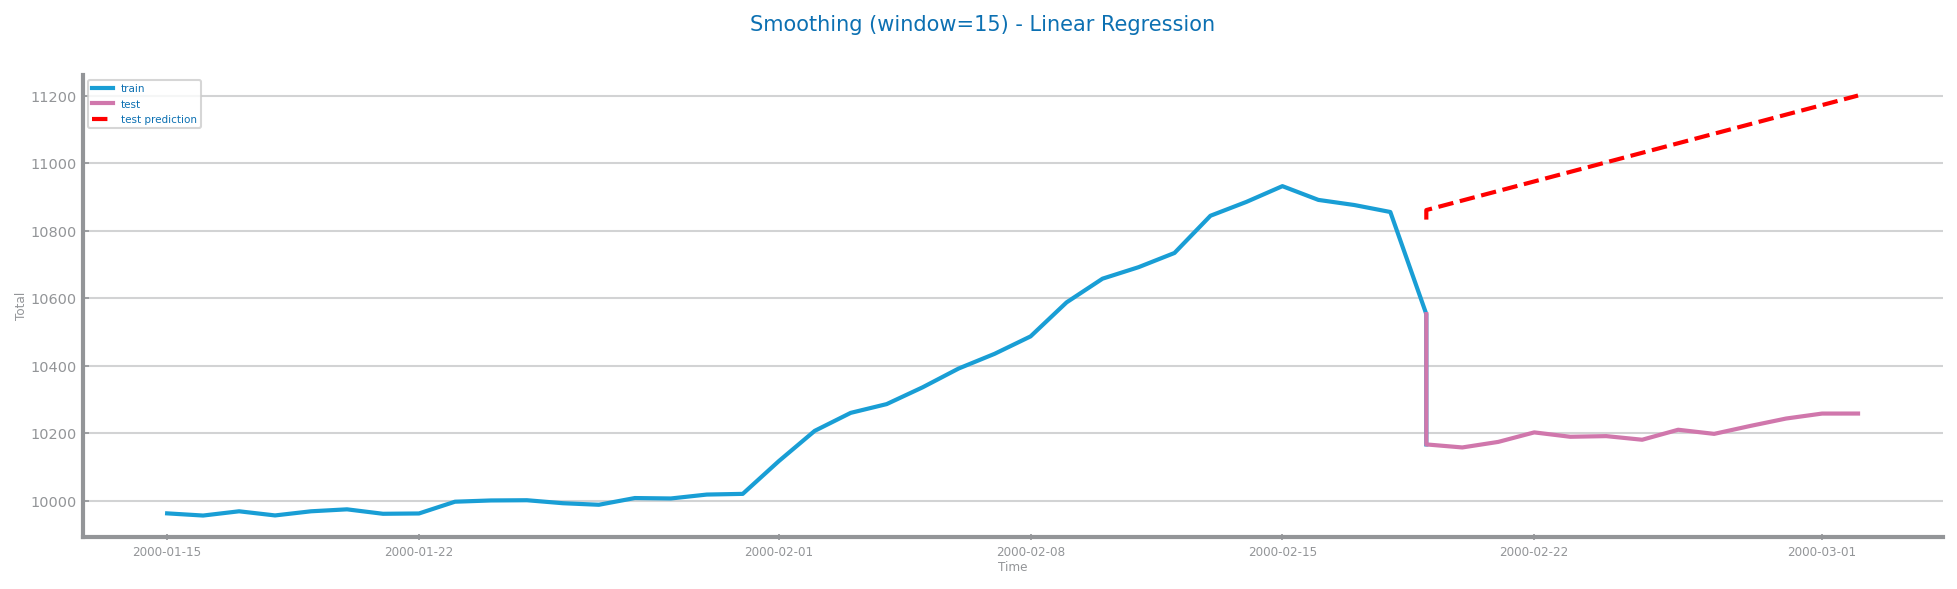

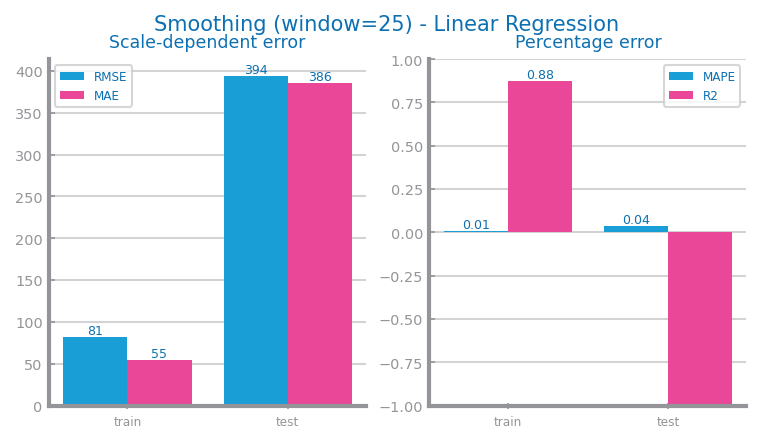

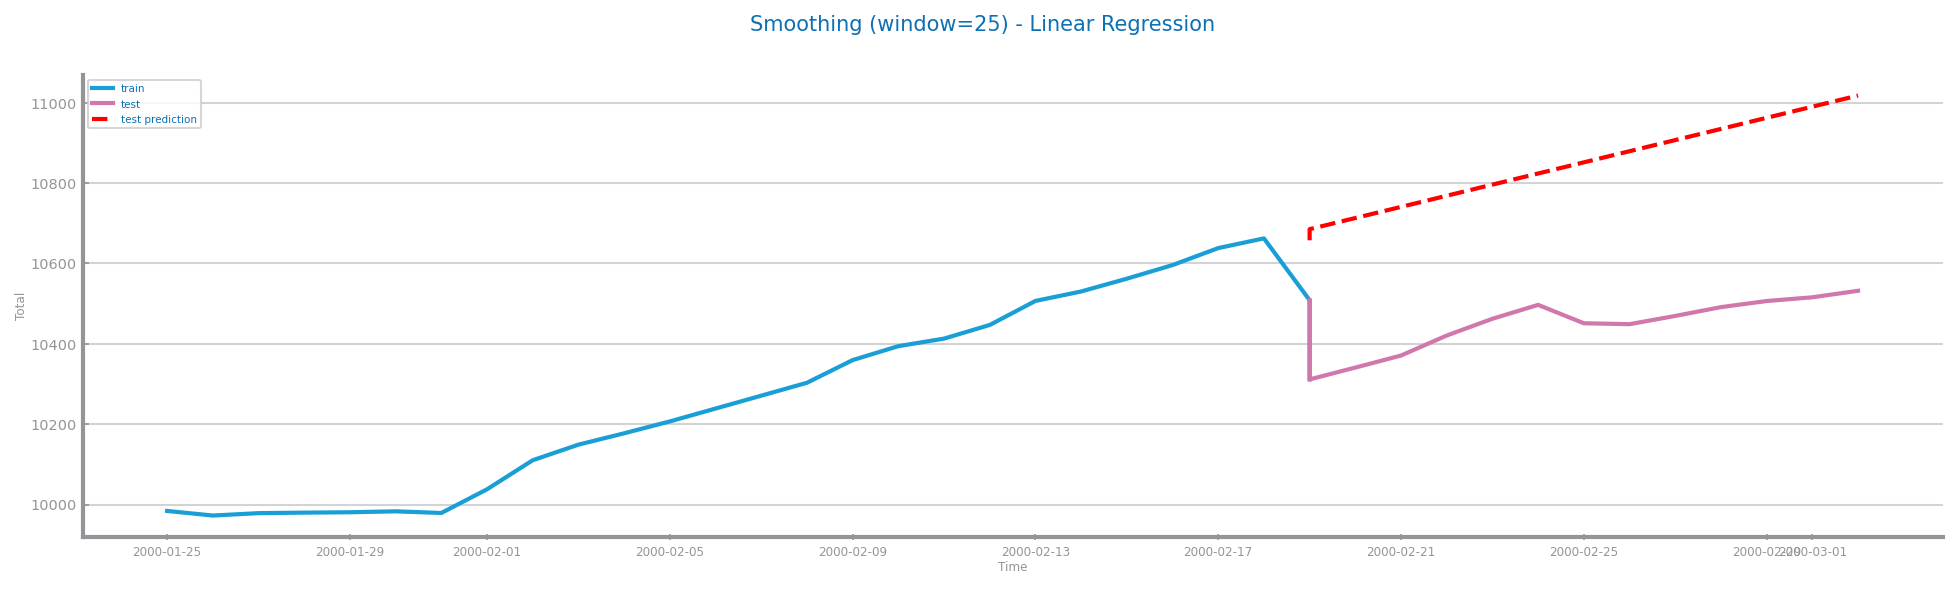

In [27]:
print("="*80)
print("LINEAR REGRESSION EVALUATION")
print("="*80)

for size in sizes:
    smooth_train = ss_smooth_list[f"size_{size}_train"]
    smooth_test = ss_smooth_list[f"size_{size}_test"]
    
    # Check if we have enough data
    if len(smooth_test) == 0:
        print(f"Skipping window size {size}: test set is empty after smoothing")
        continue
    
    # Prepare data
    n_trn = len(smooth_train)
    n_tst = len(smooth_test)
    
    trnX = arange(n_trn).reshape(-1, 1)
    trnY = smooth_train.to_numpy()
    
    tstX = arange(n_trn, n_trn + n_tst).reshape(-1, 1)
    tstY = smooth_test.to_numpy()
    
    # Train model
    model = LinearRegression()
    model.fit(trnX, trnY)
    
    prd_trn = Series(model.predict(trnX), index=smooth_train.index)
    prd_tst = Series(model.predict(tstX), index=smooth_test.index)
    
    # Store metrics
    store_metrics("Linear_Regression", size, smooth_train, smooth_test, prd_trn, prd_tst)
    
    # Plot evaluation
    plot_forecasting_eval(
        smooth_train,
        smooth_test,
        prd_trn,
        prd_tst,
        title=f"{file_tag} (window={size}) - Linear Regression"
    )
    savefig(f"../../charts/preparation/smoothing/{file_tag}_linear_regression_size{size}_eval.png")
    
    # Plot forecast
    plot_forecasting_series(
        smooth_train,
        smooth_test,
        prd_tst,
        title=f"{file_tag} (window={size}) - Linear Regression",
        xlabel="Time",
        ylabel=target,
    )
    savefig(f"../../charts/preparation/smoothing/{file_tag}_linear_regression_size{size}_forecast.png")
    
    print(f"Completed: Linear_Regression with window size {size}")

# Best Model Comparison

In [ ]:
# Convert metrics to DataFrame for easy comparison
metrics_df = DataFrame.from_dict(metrics_results, orient='index')
metrics_df = metrics_df.reset_index(drop=True)

# Display all metrics
print("="*80)
print("ALL MODEL METRICS (Test Set)")
print("="*80)
display_df = metrics_df[['model', 'window_size', 'test_rmse', 'test_mae', 'test_mape', 'test_r2']].copy()
display_df = display_df.sort_values(['model', 'window_size'])
print(display_df.to_string(index=False))
print()

# Find best models by different criteria
print("="*80)
print("BEST MODELS BY CRITERIA (Test Set)")
print("="*80)

# Best by MAPE (scale-independent, good for comparing across window sizes)
best_mape = metrics_df.loc[metrics_df['test_mape'].idxmin()]
print(f"Best MAPE: {best_mape['model']} (window={best_mape['window_size']}) = {best_mape['test_mape']:.4f}")

# Best by R2 (scale-independent)
best_r2 = metrics_df.loc[metrics_df['test_r2'].idxmax()]
print(f"Best R²: {best_r2['model']} (window={best_r2['window_size']}) = {best_r2['test_r2']:.4f}")

# Best by MAE for each window size
print(f"\nBest MAE by Window Size:")
for size in sizes:
    size_df = metrics_df[metrics_df['window_size'] == size]
    best_mae_size = size_df.loc[size_df['test_mae'].idxmin()]
    print(f"  window={size}: {best_mae_size['model']} = {best_mae_size['test_mae']:.2f}")

print()
print("="*80)
print("RECOMMENDATION")
print("="*80)
print(f"Overall Best Model: {best_mape['model']} with window size {best_mape['window_size']}")
print(f"  - Test MAPE: {best_mape['test_mape']:.4f}")
print(f"  - Test R²: {best_mape['test_r2']:.4f}")
print(f"  - Test RMSE: {best_mape['test_rmse']:.2f}")
print(f"  - Test MAE: {best_mape['test_mae']:.2f}")

# Store best model info for later use
best_model_name = best_mape['model']
best_window_size = best_mape['window_size']

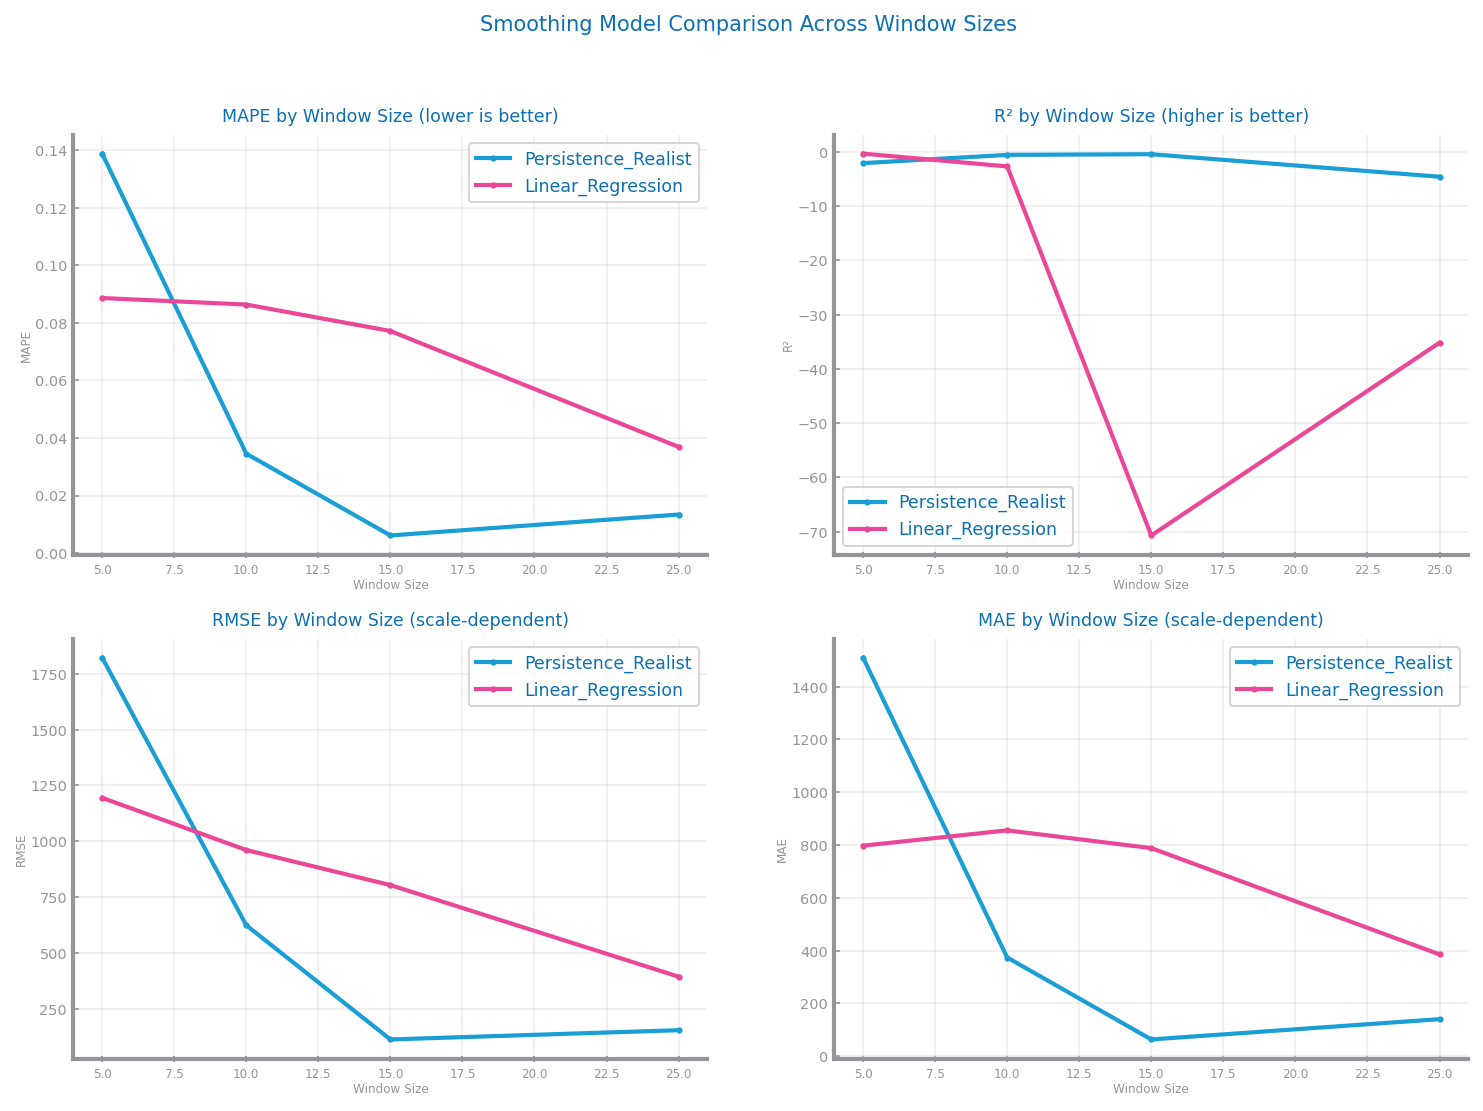

In [29]:
# Visualize model comparison
fig, axs = subplots(2, 2, figsize=(3 * HEIGHT, 2 * HEIGHT))
fig.suptitle(f"{file_tag} Model Comparison Across Window Sizes")

# Prepare data for plotting
models = metrics_df['model'].unique()
window_sizes = sorted(metrics_df['window_size'].unique())

# Plot 1: MAPE comparison (lower is better)
for model in models:
    model_data = metrics_df[metrics_df['model'] == model].sort_values('window_size')
    axs[0, 0].plot(model_data['window_size'], model_data['test_mape'], marker='o', label=model)
axs[0, 0].set_title('MAPE by Window Size (lower is better)')
axs[0, 0].set_xlabel('Window Size')
axs[0, 0].set_ylabel('MAPE')
axs[0, 0].legend(fontsize='small')
axs[0, 0].grid(True, alpha=0.3)

# Plot 2: R² comparison (higher is better)
for model in models:
    model_data = metrics_df[metrics_df['model'] == model].sort_values('window_size')
    axs[0, 1].plot(model_data['window_size'], model_data['test_r2'], marker='o', label=model)
axs[0, 1].set_title('R² by Window Size (higher is better)')
axs[0, 1].set_xlabel('Window Size')
axs[0, 1].set_ylabel('R²')
axs[0, 1].legend(fontsize='small')
axs[0, 1].grid(True, alpha=0.3)

# Plot 3: RMSE comparison
for model in models:
    model_data = metrics_df[metrics_df['model'] == model].sort_values('window_size')
    axs[1, 0].plot(model_data['window_size'], model_data['test_rmse'], marker='o', label=model)
axs[1, 0].set_title('RMSE by Window Size (scale-dependent)')
axs[1, 0].set_xlabel('Window Size')
axs[1, 0].set_ylabel('RMSE')
axs[1, 0].legend(fontsize='small')
axs[1, 0].grid(True, alpha=0.3)

# Plot 4: MAE comparison
for model in models:
    model_data = metrics_df[metrics_df['model'] == model].sort_values('window_size')
    axs[1, 1].plot(model_data['window_size'], model_data['test_mae'], marker='o', label=model)
axs[1, 1].set_title('MAE by Window Size (scale-dependent)')
axs[1, 1].set_xlabel('Window Size')
axs[1, 1].set_ylabel('MAE')
axs[1, 1].legend(fontsize='small')
axs[1, 1].grid(True, alpha=0.3)

savefig(f"../../charts/preparation/smoothing/{file_tag}_model_comparison.png")
show()

In [30]:
output_train_path = "../../data/prepared/smoothing/traffic_train_smoothing.csv"
output_test_path  = "../../data/prepared/smoothing/traffic_test_smoothing.csv"

# Select the best smoothed series based on MAPE
best_smooth_train = ss_smooth_list[f"size_{best_window_size}_train"]
best_smooth_test = ss_smooth_list[f"size_{best_window_size}_test"]

# Ensure they are DataFrames so the index is preserved cleanly
best_smooth_train.to_frame(name="Total").to_csv(output_train_path)
best_smooth_test.to_frame(name="Total").to_csv(output_test_path)

print(f"Saved window={best_window_size} smoothed train/test sets (best model: {best_model_name}).")
print(f"Train shape: {best_smooth_train.shape}")
print(f"Test shape: {best_smooth_test.shape}")

Saved window=15 smoothed train/test sets (best model: Persistence_Realist).
Train shape: (37,)
Test shape: (14,)


In [31]:
# Save metrics to CSV for reference
metrics_output_path = "../../data/prepared/smoothing/traffic_smoothing_metrics.csv"
metrics_df.to_csv(metrics_output_path, index=False)
print(f"Saved metrics to {metrics_output_path}")

# Display summary
metrics_df

Saved metrics to ../../data/prepared/smoothing/traffic_smoothing_metrics.csv


,model,window_size,train_rmse,test_rmse,train_mae,test_mae,train_mape,test_mape,train_r2,test_r2
0,Persistence_Realist,5,1656.379331,1822.014065,1583.140426,1509.842857,0.152063,0.138812,-10.563708,-2.077825
1,Persistence_Realist,10,642.923524,624.613100,506.076190,373.835714,0.047762,0.034541,-1.628829,-0.552723
2,Persistence_Realist,15,370.743977,113.534587,298.890090,63.480952,0.028442,0.006124,-0.137583,-0.428764
3,Persistence_Realist,25,234.377058,154.937471,204.038519,140.371429,0.019946,0.013391,-0.032806,-4.580779
4,Linear_Regression,5,405.475001,1194.692847,264.325435,797.562231,0.026160,0.088632,0.307044,-0.323284
5,Linear_Regression,10,244.032073,961.206723,176.153177,855.413947,0.017066,0.086362,0.621263,-2.677099
6,Linear_Regression,15,171.937313,804.228570,130.714817,788.243406,0.012630,0.077168,0.755333,-70.690755
7,Linear_Regression,25,81.473740,394.421861,54.928182,385.711726,0.005322,0.036899,0.875197,-35.166281
